## This notebook shows the code for plotting the demographics for death rate vs poverty rate for each of the US regions 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly, json
import plotly.express as px
from urllib.request import urlopen

sns.set_style("whitegrid")

In [2]:
pip install -U kaleido

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install plotly==5.11.0

Note: you may need to restart the kernel to use updated packages.


In [67]:
# Get data for specific groups of people (you only want one data point per county when you plot)
import numpy as np
import pandas as pd
import plotly, json
import plotly.express as px
from urllib.request import urlopen

# Get county/mort stuff
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response: counties = json.load(response)
mort = pd.read_csv('.../mort_with_15yrpoverty.csv',dtype={"FIPS": str})

# This masks the unreliable data
mask = mort['Unreliable']==False
df = mort.loc[mask]

# The function
def flatten_df(df, filter_by = {}, save_fn = None): 
    
    sort_by = {'Gender Code' : None,
               'Race' : None,
               'Hispanic Origin' : None,
               'Interval' : None,
               'Age Group Code': None,
               'State' : None}
    county_level_cols = ['County','5_Year_Avg_Poverty_Estimate','Total 5yrAvg County Population',
                         'Total 5yrAvg County Population','Total 5yrAvg County Deaths',
                         'Total 5yrAvg State Population','Total 5yrAvg State Deaths',
                         'Total 15yrAvg County Population','Total 15yrAvg County Deaths',
                         'Total 15yrAvg State Population','Total 15yrAvg State Deaths']
    '''
    ,'CO 2nd Max 1-hr', 'CO 2nd Max 8-hr','NO2 98th Percentile 1-hr', 
    'NO2 Mean 1-hr', 'Ozone 2nd Max 1-hr', 'Ozone 4th Max 8-hr', 
    'SO2 99th Percentile 1-hr', 'SO2 2nd Max 24-hr','SO2 Mean 1-hr', 
    'PM2.5 98th Percentile 24-hr', 'PM2.5 Weighted Mean 24-hr', 
    'PM10 2nd Max 24-hr', 'Lead Max 3-Mo Avg',
    '''
    
    # Check for bad input
    for key in filter_by.keys(): 
        if key not in sort_by: 
            print('Unrecognized key in filter_by dict.')
            return
    
    for key in filter_by:
        if filter_by[key] != None: sort_by[key] = filter_by[key]
    
    # Remove all unnecesary data from the df
    temp_df = df.copy(deep=True)

    for key,val in sort_by.items():
        if val == None: 
            temp_df = temp_df.drop(columns=key)
        else:    
            temp_df = temp_df.loc[np.asarray(temp_df[key]==val)]
            
    # Flatten remaining data points so that there are no repeated counties/FIPS
    fips,ind = np.unique(temp_df['FIPS'],return_index=True)
    
    ### Get values that are constant for different groups in the same county
    county_levels = {}
    for col in county_level_cols:
        county_levels[col] = np.asarray(temp_df[col])[ind]
        
    ### Calculate the values that change with different groups in the same county
    deaths = []
    population = []
    for fip in fips:
        mask = np.asarray(temp_df['FIPS']==fip)
        single_county_df = temp_df.loc[mask]
        deaths.append(np.sum(single_county_df['Deaths']))
        population.append(np.sum(single_county_df['Population']))
    
    ### Calculate deaths and population per year
    if sort_by['Interval'] != None: num_years = 5
    else: num_years = 15
    deaths = np.asarray(deaths)/num_years
    population = np.asarray(population)/num_years
        
    flattened_df = pd.DataFrame(data={'FIPS': fips, 'Deaths': deaths, 'Population': population})
    for col in county_level_cols:
        flattened_df[col] = county_levels[col]
    
    # Save to CSV if necessary
    if save_fn != None:
        flattened_df.to_csv(save_fn)
    
    return flattened_df # dataframe with single row for each county containing deaths, population, poverty, and polution

In [21]:
# Gives all the options for the different columns  
print(np.unique(np.asarray(mort['Race'],dtype=str)),'\n')
print(np.unique(np.asarray(mort['Age Group Code'],dtype=str)),'\n')
print(np.unique(np.asarray(mort['Hispanic Origin'],dtype=str)),'\n')
print(np.unique(np.asarray(mort['Gender Code'],dtype=str)),'\n')
print(np.unique(np.asarray(mort['Interval'],dtype=str)))


['American Indian or Alaska Native' 'Asian or Pacific Islander'
 'Black or African American' 'White' 'nan'] 

['1' '1-4' '10-14' '15-19' '20-24' '25-34' '35-44' '45-54' '5-9' '55-64'
 '65-74' '75-84' '85+' 'NS' 'nan'] 

['Hispanic or Latino' 'Not Hispanic or Latino' 'Not Stated' 'nan'] 

['F' 'M' 'nan'] 

['2002-2006' '2007-2011' '2012-2016']


In [68]:
# Look for the desired interval data (2012-2016)
mort_flattened = flatten_df(df,{'Interval':'2012-2016'})
mort_flattened

,FIPS,Deaths,Population,County,5_Year_Avg_Poverty_Estimate,Total 5yrAvg County Population,Total 5yrAvg County Deaths,Total 5yrAvg State Population,Total 5yrAvg State Deaths,Total 15yrAvg County Population,Total 15yrAvg County Deaths,Total 15yrAvg State Population,Total 15yrAvg State Deaths
0,01001,487.4,29703.6,"Autauga County, AL",7205.6,34145.0,495.4,3436910.2,49531.2,32042.933333,436.133333,3.353935e+06,47131.000000
1,01003,1906.8,134340.6,"Baldwin County, AL",25849.6,147086.2,1926.4,3436910.2,49531.2,133171.666667,1722.066667,3.353935e+06,47131.000000
2,01005,251.6,9629.6,"Barbour County, AL",6731.2,13496.4,263.0,3436910.2,49531.2,13907.333333,267.600000,3.353935e+06,47131.000000
3,01007,200.8,9249.4,"Bibb County, AL",4268.2,12976.2,227.2,3436910.2,49531.2,12391.600000,215.466667,3.353935e+06,47131.000000
4,01009,587.4,34588.2,"Blount County, AL",9114.8,37613.8,591.0,3436910.2,49531.2,37446.000000,550.333333,3.353935e+06,47131.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3048,56037,246.0,22470.0,"Sweetwater County, WY",3989.0,25804.6,261.6,327242.6,4303.2,23872.066667,243.133333,3.062673e+05,4045.533333
3049,56039,72.0,5498.6,"Teton County, WY",1706.4,10321.8,80.6,327242.6,4303.2,8629.533333,71.000000,3.062673e+05,4045.533333
3050,56041,120.6,8360.4,"Uinta County, WY",2291.0,10731.0,126.0,327242.6,4303.2,10038.333333,117.866667,3.062673e+05,4045.533333
3051,56043,67.2,2090.4,"Washakie County, WY",988.0,3961.6,76.4,327242.6,4303.2,3246.066667,75.933333,3.062673e+05,4045.533333


In [69]:
# For demographics purpose, select a race and interval 
mort_flattened_d = flatten_df(df,{'Race':'White','Interval':'2012-2016'})
mort_flattened_d

,FIPS,Deaths,Population,County,5_Year_Avg_Poverty_Estimate,Total 5yrAvg County Population,Total 5yrAvg County Deaths,Total 5yrAvg State Population,Total 5yrAvg State Deaths,Total 15yrAvg County Population,Total 15yrAvg County Deaths,Total 15yrAvg State Population,Total 15yrAvg State Deaths
0,01001,417.2,26182.8,"Autauga County, AL",7205.6,34145.0,495.4,3436910.2,49531.2,32042.933333,436.133333,3.353935e+06,47131.000000
1,01003,1778.0,126691.0,"Baldwin County, AL",25849.6,147086.2,1926.4,3436910.2,49531.2,133171.666667,1722.066667,3.353935e+06,47131.000000
2,01005,157.2,5800.2,"Barbour County, AL",6731.2,13496.4,263.0,3436910.2,49531.2,13907.333333,267.600000,3.353935e+06,47131.000000
3,01007,188.4,8850.6,"Bibb County, AL",4268.2,12976.2,227.2,3436910.2,49531.2,12391.600000,215.466667,3.353935e+06,47131.000000
4,01009,587.4,34588.2,"Blount County, AL",9114.8,37613.8,591.0,3436910.2,49531.2,37446.000000,550.333333,3.353935e+06,47131.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3034,56037,246.0,22470.0,"Sweetwater County, WY",3989.0,25804.6,261.6,327242.6,4303.2,23872.066667,243.133333,3.062673e+05,4045.533333
3035,56039,72.0,5498.6,"Teton County, WY",1706.4,10321.8,80.6,327242.6,4303.2,8629.533333,71.000000,3.062673e+05,4045.533333
3036,56041,120.6,8360.4,"Uinta County, WY",2291.0,10731.0,126.0,327242.6,4303.2,10038.333333,117.866667,3.062673e+05,4045.533333
3037,56043,67.2,2090.4,"Washakie County, WY",988.0,3961.6,76.4,327242.6,4303.2,3246.066667,75.933333,3.062673e+05,4045.533333


In [74]:
# Joining columns FIPS and Population into main dataframe. Use FIPS as the matching index, add a _W to the new column 
mort_flattened = mort_flattened.join(mort_flattened_d[['FIPS', 'Population']].set_index('FIPS'), rsuffix='_W', how='left', on='FIPS')

In [75]:
mort_flattened

,FIPS,Deaths,Population,County,5_Year_Avg_Poverty_Estimate,Total 5yrAvg County Population,Total 5yrAvg County Deaths,Total 5yrAvg State Population,Total 5yrAvg State Deaths,Total 15yrAvg County Population,Total 15yrAvg County Deaths,Total 15yrAvg State Population,Total 15yrAvg State Deaths,Population_W
0,01001,487.4,29703.6,"Autauga County, AL",7205.6,34145.0,495.4,3436910.2,49531.2,32042.933333,436.133333,3.353935e+06,47131.000000,26182.8
1,01003,1906.8,134340.6,"Baldwin County, AL",25849.6,147086.2,1926.4,3436910.2,49531.2,133171.666667,1722.066667,3.353935e+06,47131.000000,126691.0
2,01005,251.6,9629.6,"Barbour County, AL",6731.2,13496.4,263.0,3436910.2,49531.2,13907.333333,267.600000,3.353935e+06,47131.000000,5800.2
3,01007,200.8,9249.4,"Bibb County, AL",4268.2,12976.2,227.2,3436910.2,49531.2,12391.600000,215.466667,3.353935e+06,47131.000000,8850.6
4,01009,587.4,34588.2,"Blount County, AL",9114.8,37613.8,591.0,3436910.2,49531.2,37446.000000,550.333333,3.353935e+06,47131.000000,34588.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3048,56037,246.0,22470.0,"Sweetwater County, WY",3989.0,25804.6,261.6,327242.6,4303.2,23872.066667,243.133333,3.062673e+05,4045.533333,22470.0
3049,56039,72.0,5498.6,"Teton County, WY",1706.4,10321.8,80.6,327242.6,4303.2,8629.533333,71.000000,3.062673e+05,4045.533333,5498.6
3050,56041,120.6,8360.4,"Uinta County, WY",2291.0,10731.0,126.0,327242.6,4303.2,10038.333333,117.866667,3.062673e+05,4045.533333,8360.4
3051,56043,67.2,2090.4,"Washakie County, WY",988.0,3961.6,76.4,327242.6,4303.2,3246.066667,75.933333,3.062673e+05,4045.533333,2090.4


## 1. US regions assignments: 

In [76]:
# Grouping the US states into different regions: West, Midwest, Northeast, South 
West = ['WA', 'OR','MT','ID','WY','CA','NV','UT','CO','AZ','NM', 'AK', 'HI']
Midwest = ['ND','SD','NE','KS','MN','IA','MD','WI','IL','MI','IN','OH', 'MO']
Northeast = ['PA','NY','NJ','CT','MA','RI','VT','NH','ME', 'DC']
South = ['TX','OK','AR','LA','MS','KY','TN','AL','WV','VA','NC','SC','GA','FL','MD','DE']

In [77]:
# Dictionary that maps states abbrev. to the regions 
dict_regions = {}
for state in West:
    dict_regions.update({state: 'West'})
for state in Midwest:
    dict_regions.update({state: 'Midwest'})
for state in Northeast:
    dict_regions.update({state: 'Northeast'})
for state in South:
    dict_regions.update({state: 'South'})

In [79]:
# Creating new columns for the rates, eliminating zeros and ones in the data 
mort_flattened.loc[:,'PovertyRate'] = mort_flattened.loc[:,'5_Year_Avg_Poverty_Estimate']/mort_flattened.loc[:,'Population']
mort_flattened.loc[:,'DeathRate'] = (mort_flattened.loc[:,'Deaths']/mort_flattened.loc[:,'Population'])
mort_flattened.loc[:,'WhitePop'] = (mort_flattened.loc[:,'Population_W']/mort_flattened.loc[:,'Population'])

# Extract the states abbrev. into a new column to facilitate sorting latter  
mort_flattened.loc[:,'State'] = mort_flattened.loc[:,'County'].apply(lambda x: x.split(',')[1][1:])

# Assign a region based on the state abbrev. using the previous dictionary 
mort_flattened.loc[:,'Region'] = mort_flattened.loc[:,'State'].apply(lambda x: dict_regions.get(x))

In [86]:
mort_flattened

,FIPS,Deaths,Population,County,5_Year_Avg_Poverty_Estimate,Total 5yrAvg County Population,Total 5yrAvg County Deaths,Total 5yrAvg State Population,Total 5yrAvg State Deaths,Total 15yrAvg County Population,Total 15yrAvg County Deaths,Total 15yrAvg State Population,Total 15yrAvg State Deaths,Population_W,PovertyRate,DeathRate,WhitePop,State,Region
0,01001,487.4,29703.6,"Autauga County, AL",7205.6,34145.0,495.4,3436910.2,49531.2,32042.933333,436.133333,3.353935e+06,47131.000000,26182.8,0.242583,0.016409,0.881469,AL,South
1,01003,1906.8,134340.6,"Baldwin County, AL",25849.6,147086.2,1926.4,3436910.2,49531.2,133171.666667,1722.066667,3.353935e+06,47131.000000,126691.0,0.192418,0.014194,0.943058,AL,South
2,01005,251.6,9629.6,"Barbour County, AL",6731.2,13496.4,263.0,3436910.2,49531.2,13907.333333,267.600000,3.353935e+06,47131.000000,5800.2,0.699011,0.026128,0.602330,AL,South
3,01007,200.8,9249.4,"Bibb County, AL",4268.2,12976.2,227.2,3436910.2,49531.2,12391.600000,215.466667,3.353935e+06,47131.000000,8850.6,0.461457,0.021710,0.956884,AL,South
4,01009,587.4,34588.2,"Blount County, AL",9114.8,37613.8,591.0,3436910.2,49531.2,37446.000000,550.333333,3.353935e+06,47131.000000,34588.2,0.263523,0.016983,1.000000,AL,South
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3048,56037,246.0,22470.0,"Sweetwater County, WY",3989.0,25804.6,261.6,327242.6,4303.2,23872.066667,243.133333,3.062673e+05,4045.533333,22470.0,0.177526,0.010948,1.000000,WY,West
3049,56039,72.0,5498.6,"Teton County, WY",1706.4,10321.8,80.6,327242.6,4303.2,8629.533333,71.000000,3.062673e+05,4045.533333,5498.6,0.310334,0.013094,1.000000,WY,West
3050,56041,120.6,8360.4,"Uinta County, WY",2291.0,10731.0,126.0,327242.6,4303.2,10038.333333,117.866667,3.062673e+05,4045.533333,8360.4,0.274030,0.014425,1.000000,WY,West
3051,56043,67.2,2090.4,"Washakie County, WY",988.0,3961.6,76.4,327242.6,4303.2,3246.066667,75.933333,3.062673e+05,4045.533333,2090.4,0.472637,0.032147,1.000000,WY,West


## 2. Plot of the demographics for poverty rate vs death rate in the US

In [80]:
import matplotlib.colors as colors
import itertools

#Define min/max scaling
scalemin = 0
scalemax = 1

# Normalize data if needed 
norm = colors.Normalize()
norm.vmax = scalemax
norm.vmin = scalemin

#Select the colormap to use. Jet option has a gradient of different colors
cmap = plt.cm.jet

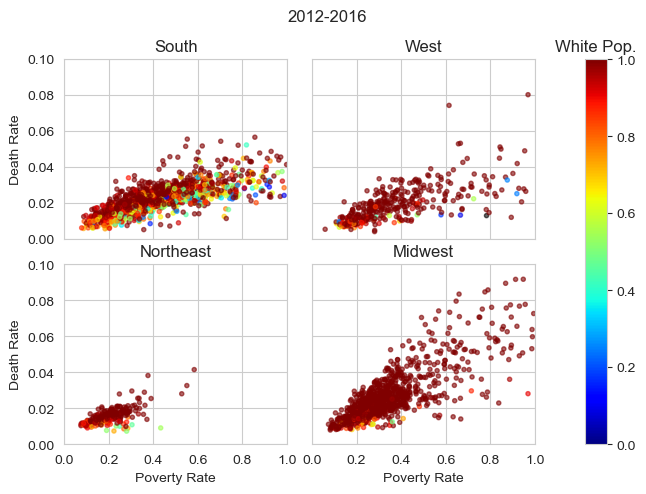

In [98]:
# Configure the figure's resolution in dots per inch
plt.rcParams['figure.dpi']=100

from mpl_toolkits.axes_grid1 import AxesGrid 
# Modify the figure size 
fig = plt.figure(figsize=(7,5))

# Set up the grid axis, the number of columns, the location of the colorbar 
grid = AxesGrid(fig, 110,
                nrows_ncols=(2,2),
                axes_pad=0.25,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.5,
                aspect=False)

# List of markers that could be iterated, use if needed  
# markers = itertools.cycle(['o','s','v', 'p', '*', 'D'])

# Iteration of plotting region in a axis, ex: first region -South- plotted in the first axis, ... 
axindex=0    
for region in mort_flattened.Region.drop_duplicates():
    ax = grid[axindex]
    #Store the values for selected region 
    curdf = mort_flattened[mort_flattened.Region==region]
    s = ax.scatter(curdf.PovertyRate, curdf.DeathRate, color=cmap(norm(np.array(curdf.WhitePop))), marker='.',alpha=0.6)

    #Set up labels, titles for the figure 
    s.set_label(region)    
    ax.set_title(region, fontsize=12)
    ax.set_xlim(0,1)
    ax.set_ylim(0,0.1)
    ax.set_xlabel('Poverty Rate')
    ax.set_ylabel('Death Rate')
    
    axindex = axindex+1
     
# plt.xlim(0,1)
# plt.ylim(0,0.1)

#Add a legend colorbar:
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = plt.colorbar(sm, cax=ax.cax)
# cb.set_label('WhiteDeathRate', rotation=270)
cb.ax.set_title('White Pop.', fontsize=12)

# save fig 
fig.suptitle('2012-2016')
# plt.savefig('2012-2016_WhitePop_Regionsdemog.png')

plt.show()

__________________________________________________________________________________________________________________________________________________
END OF MAIN SECTION 